# *Marcel Nguemaha, Feb 27, 2019*

# Yammer: Investigating a Drop in User Engagement

Yammer is a social network for communicating with coworkers. Individuals share documents, updates, and ideas by posting them in groups, it’s like Slack. Yammer is free to use indefinitely, but companies must pay license fees if they want access to administrative controls, including integration with user management systems like ActiveDirectory.

# The problem

You show up to work Tuesday morning, September 2, 2014. The head of the Product team walks over to your desk and asks you what you think about the latest activity on the user engagement dashboards (yes this really happens). You fire them up, and something immediately jumps out: **There is a sudden sharp decrease in engagement around Aug 1**

The engagement chart shows the number of engaged users each week. Yammer defines engagement as having made some type of server call by interacting with the product (shown in the data as events of type “engagement”). Any point in this chart can be interpreted as “the number of users who logged at least one engagement event during the week starting on that date.”

# The Question:
The head of product says “Can you look into this and get me a summary by this afternoon?”  As she runs to a meeting.


---

# Hypothesis

- 1) It's possible that the sudden drop around **August 1st** is due to a decrease in engagement for a particular group of users. If that is the case, which ones? 

- 2) It's possible that the observed trend is repetitive, perhaps it happens every year and has nothing to do with this particular year. If this is the case, something might be wrong wiht the platform itself.

# Plan of Action

- a) Reproduce the observed trend

- b) If there is engagement data from previous years, check if the present trend has happened in other years

- c) After reproducing the trend, make similar plots for different users
    - location
    - langauge
    - device used
    - etc
   
  
  ---


In [1]:
#https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d
from google.colab import drive
ROOT = "/content/drive/"
drive.mount(ROOT)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import sys, os

In [0]:
from importlib.machinery import SourceFileLoader
MODULE_PATH = ROOT+'My Drive/pytools'
eda = SourceFileLoader('eda', os.path.join(MODULE_PATH, 'eda.py')).load_module()


In [0]:
def load_data(file_name, date_attribs=None):
  
    path = ("/content/drive/My Drive/"+
    "InsightsFellow/HealthData/"+
    "data_challenges/2yammer_user_engagement/")
  
    df = pd.read_csv(
      path+file_name,
      parse_dates = date_attribs
    )
    return df

In [0]:
#load the data files
users = load_data('yammer_users.csv', date_attribs=['created_at', 'activated_at'])
events = load_data('yammer_events.csv', date_attribs=['occurred_at'])
emails = load_data('yammer_emails.csv', date_attribs=['occurred_at'])
periods = load_data('dimension_rollup_periods.csv', date_attribs=[1,2,3,4,5])

In [0]:
def merge_data(users, events, periods, period_id=1007):
  # merge three dataframes into one
  
  mask = ((periods.period_id == period_id) & 
       (( (periods.pst_start.dt.year >= 2013) &
       (periods.pst_start.dt.month >= 5)   ) &
       (periods.pst_start.dt.year < 2015)))
  
  period_1007 = periods[mask]
  
  period_1007_sub = period_1007[['pst_start', 'time_id']].copy()
  period_1007_sub['pst_start'] = pd.to_datetime(period_1007_sub.pst_start.apply(datetime.datetime.date))
  events['pst_start'] = pd.to_datetime(events.occurred_at.apply(datetime.datetime.date))
  
  merged = events.merge(period_1007_sub, left_on='pst_start', right_on='pst_start')
  mask = (merged.event_type=='engagement')
  merged = merged[mask]

  engagement_df = merged.merge(users, how='left', left_on='user_id', right_on='user_id')
  
  return engagement_df


def rolling_sum(df, roll_on, mintime, maxtime, window_size=1):
  
  #counts the number of use engagement per period_id
  from datetime import timedelta
  
  results = {}
  min_time = mintime 
  max_time = maxtime 
  
  while min_time <= max_time-timedelta(days=window_size+1):
    
    stop_time = min_time + timedelta(days=window_size)
    
    interval = ( ((df[roll_on] >= min_time) & (df[roll_on] < stop_time)) ) 
             

    count = df[interval]['event_type'].count()
 
    results[stop_time] = [count]

    min_time = stop_time

  #take the transpose to have correct columns
  results = pd.DataFrame(results).T

  return results

def make_plot(results, mintime, maxtime):
  
  ax = results.plot()
  mintime = pd.Timestamp('2014-05-10 00:00:00') 
  maxtime = pd.Timestamp('2014-09-05 00:00:00') 
  _= plt.xlim(mintime, maxtime)
  _= plt.legend([])
  plt.title('Weekly User Engagements')

# a) Reproducing The Trend

In order to better understand what the plot means, I will first merge the **users, events**, and **periods** datasets, and then reproduce to observe trend in user engagements. 

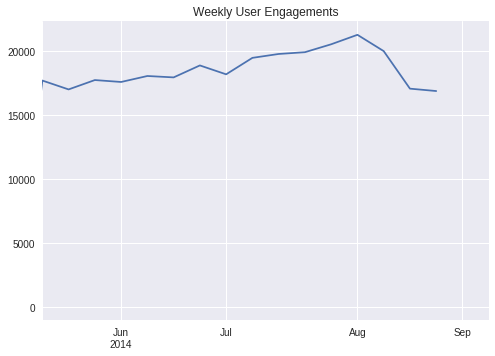

In [7]:
min_time = pd.Timestamp('2014-05-01 00:00:00')
max_time = pd.Timestamp('2014-09-01 00:00:00')

df = merge_data(users, events, periods, period_id=1007)
results = rolling_sum(df, 'time_id', min_time, max_time, 7)
make_plot(results, min_time, max_time)


The above plot shows the total number of users who were recored as **engaged** with the systems for the period of interest (period 1007). Indeed, there is a sudden decrease around ***Aug 1**

# b) Looking at previous years

In [8]:
#Check time range with event data
print("Minimum Recorded Time", events.occurred_at.min())
print("Minimum Recorded Time", events.occurred_at.max())

Minimum Recorded Time 2014-05-01 00:54:09
Minimum Recorded Time 2014-08-31 23:03:39


Unfortunately, we do not have data from previous years. We are unable to check if the sudden drop is something recurrent. 

# Breaking it Down, What Contributed to the Drop?

In [0]:
def get_engagements(df, column):
  
  min_time = pd.Timestamp('2014-05-01 00:00:00')
  max_time = pd.Timestamp('2014-09-01 00:00:00')
  
  results = {}
  for name in list(df[column].unique()):
    
    df_name = df[df[column]==name]
    data = rolling_sum(df_name, 'time_id', min_time, max_time, 7)
    results[name] = data[0].values
  results = pd.DataFrame(results, index=data[0].index)
  
  return results


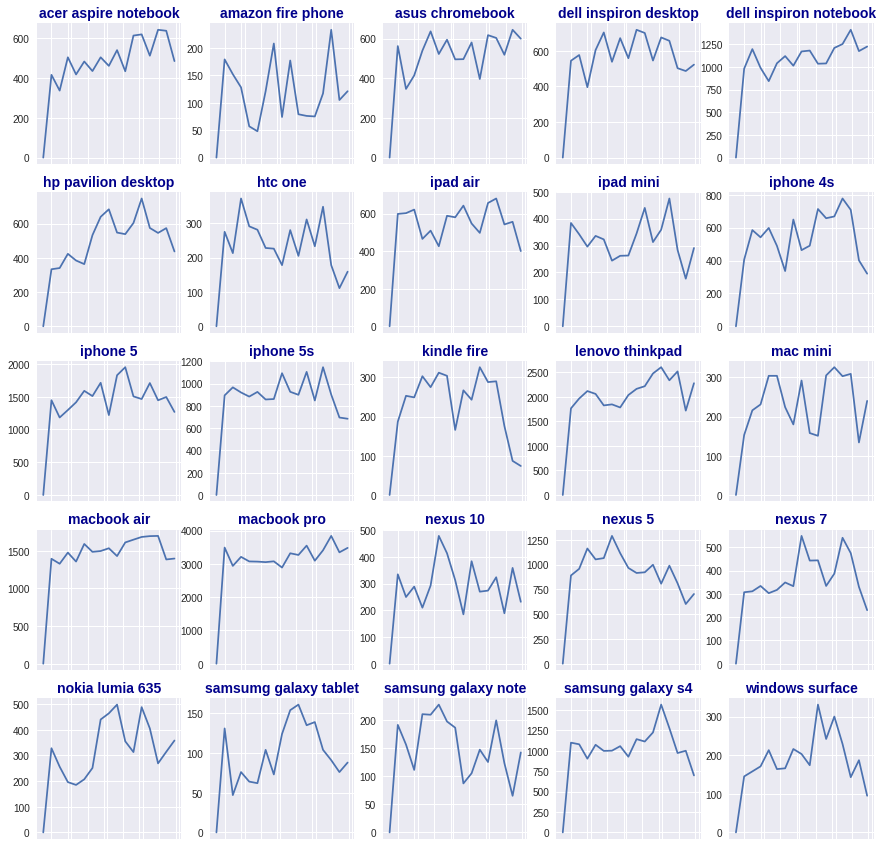

In [10]:
eng = get_engagements(df, 'device')
fig = plt.figure(1, figsize=(15,15))
columns = list(eng.columns[1:])
i = 1
for col in columns:
  
  ax = fig.add_subplot(5,5,i)
  _ = ax.plot(eng.index, eng[col])
  i = i+1
  _= plt.title(col, fontsize = 14, fontweight = 'bold', color = 'darkblue')
  if i < 22:
        _= ax.set_xticklabels(['' for x in ax.get_xticks()])
  else:
     _= ax.set_xticklabels(['' for x in ax.get_xticks()])

#### Summary Looking at different type of devices

Looking at the number of users per device used, there is nothing striking about any particular device. Hence, the drop may not be directly related to the type of device used. 

## Looking at Locations

Below, I will create a plot of the number of users for each country. This is to check if there is anything particular about users from a given country

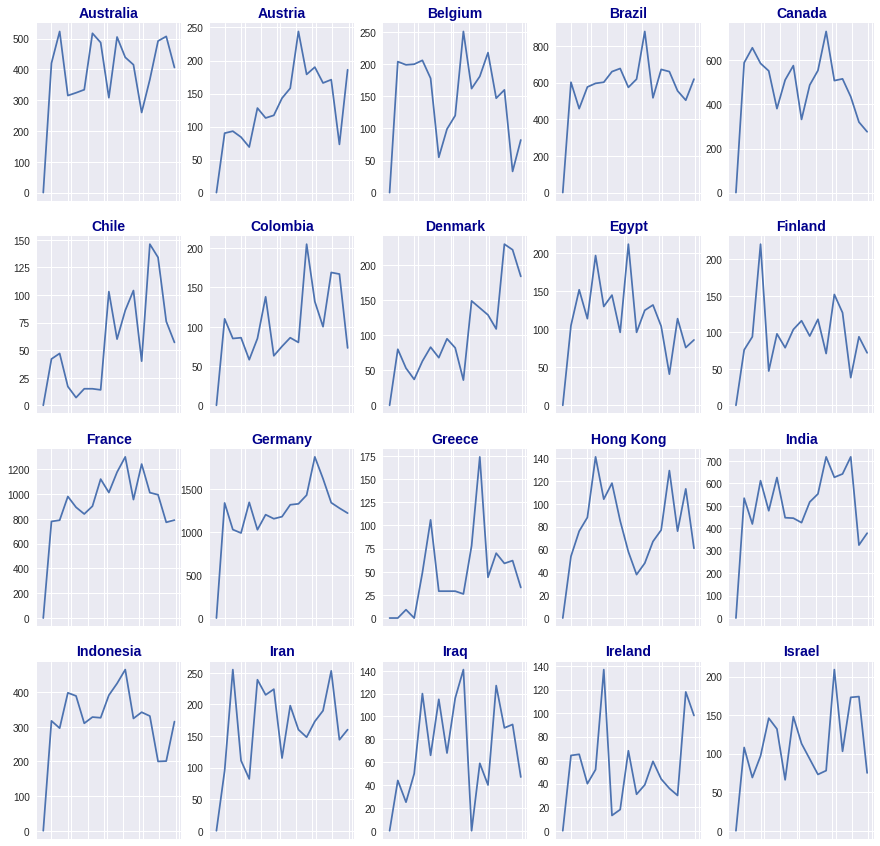

In [11]:
#looking at locations
loc = get_engagements(df, 'location')
fig = plt.figure(1, figsize=(15,15))
columns = list(loc.columns[1:21])
i = 1
for col in columns:
  
  ax = fig.add_subplot(4,5,i)
  _ = ax.plot(loc.index, loc[col])
  i = i+1
  _= plt.title(col, fontsize = 14, fontweight = 'bold', color = 'darkblue')
  if i < 22:
        _= ax.set_xticklabels(['' for x in ax.get_xticks()])
  else:
     _= ax.set_xticklabels(['' for x in ax.get_xticks()])

20

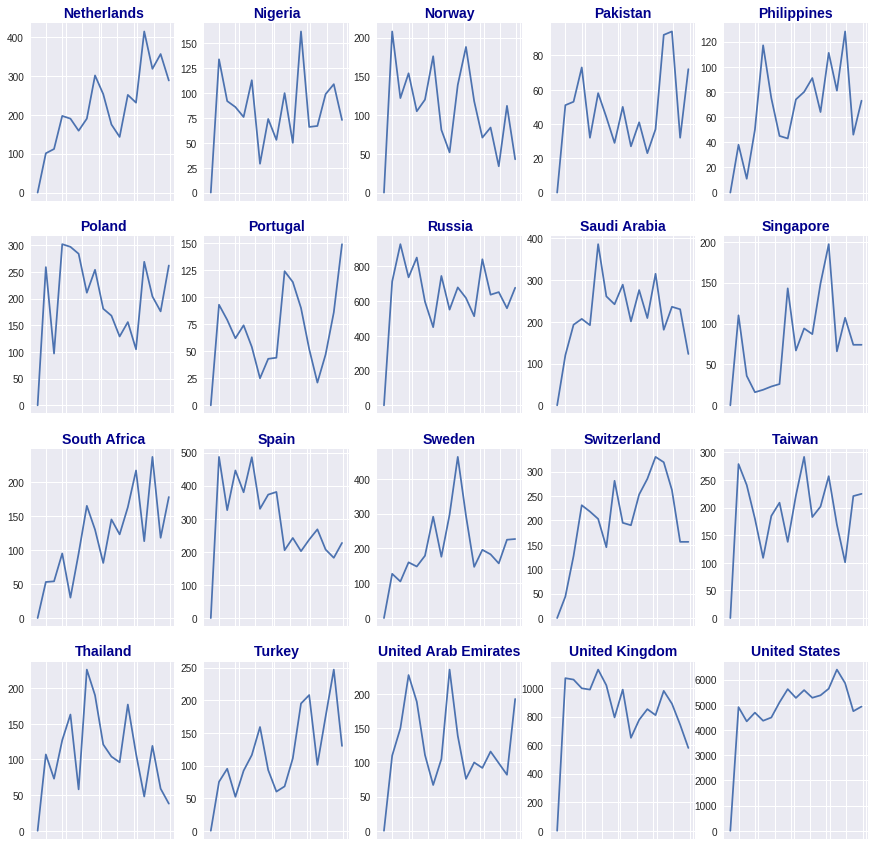

In [12]:
#looking at locations
loc = get_engagements(df, 'location')
fig = plt.figure(1, figsize=(15,15))
columns = list(loc.columns[26:46])
i = 1
len(columns)
for col in columns:
  
  ax = fig.add_subplot(4,5,i)
  _ = ax.plot(loc.index, loc[col])
  i = i+1
  _= plt.title(col, fontsize = 14, fontweight = 'bold', color = 'darkblue')
  if i < 22:
        _= ax.set_xticklabels(['' for x in ax.get_xticks()])
  else:
     _= ax.set_xticklabels(['' for x in ax.get_xticks()])

#### Summary looking at user locations

There is also not much we can say about user location. However, it appears that the trend for user engagements for users in the USA most closely ressembles the trend we have in the problem statement. So we can investigate users in the USA further, making the assumption that these users are representative of the situation depicted in the problem.

# Focusing on USA users

In [0]:
to_drop = ['user_id',	'occurred_at','location', 'pst_start', 'created_at', 'activated_at']
usa_df = df[df.location=='United States'].drop(to_drop, axis=1)

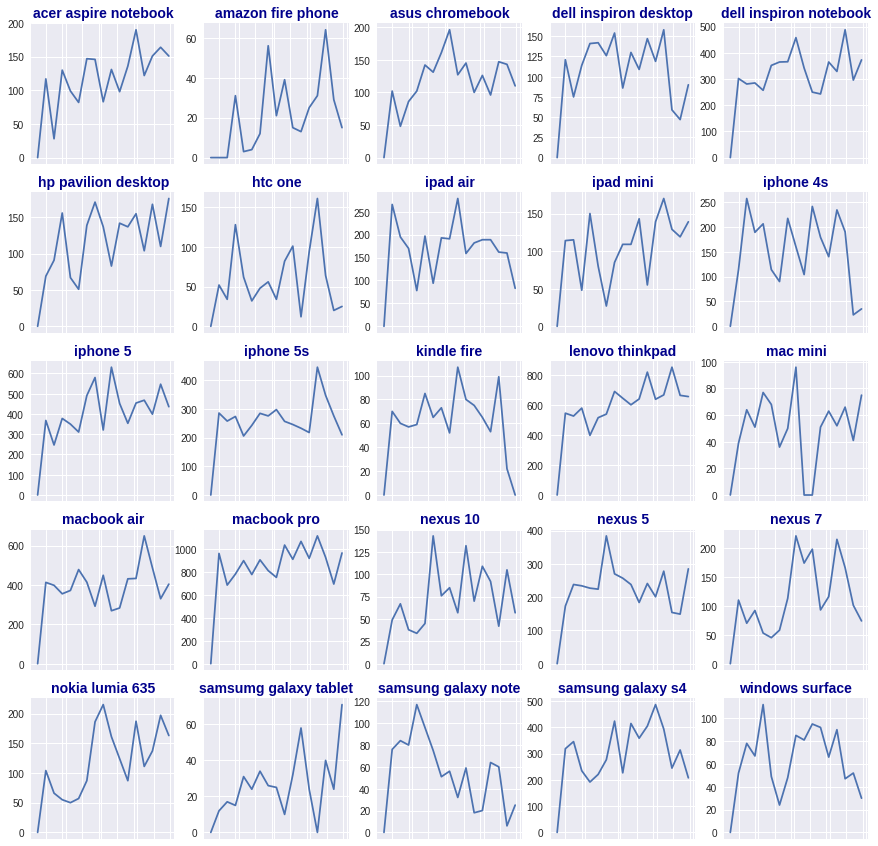

In [14]:
usa_df_eng = get_engagements(usa_df, 'device')
fig = plt.figure(1, figsize=(15,15))
columns = list(usa_df_eng.columns[1:])
i = 1
for col in columns:
  
  ax = fig.add_subplot(5,5,i)
  _ = ax.plot(usa_df_eng.index, usa_df_eng[col])
  i = i+1
  _= plt.title(col, fontsize = 14, fontweight = 'bold', color = 'darkblue')
  if i < 22:
        _= ax.set_xticklabels(['' for x in ax.get_xticks()])
  else:
     _= ax.set_xticklabels(['' for x in ax.get_xticks()])

## Dominating Language

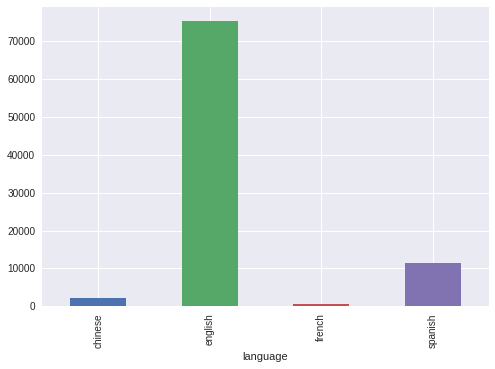

In [15]:
_= usa_df.groupby('language').count().event_type.plot(kind='bar')

The above plot shows that users are mostly English and Spanish. Creating a separate plot for user engagement per week as shown below, we find that the trend in Chinese and French speaking users is mostly noise. 

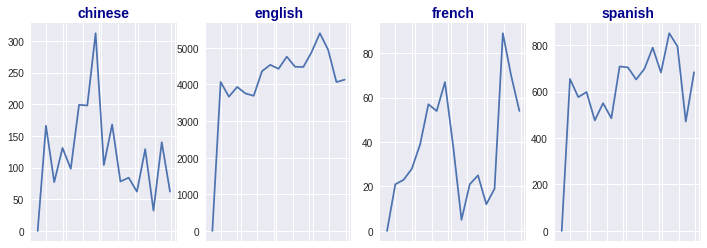

In [16]:
usa_df_eng_utype = get_engagements(usa_df, 'language')
fig = plt.figure(1, figsize=(12,4))
columns = list(usa_df_eng_utype.columns[0:])
i = 1
for col in columns:
  
  ax = fig.add_subplot(1,4,i)
  _ = ax.plot(usa_df_eng_utype.index, usa_df_eng_utype[col])
  i = i+1
  _= plt.title(col, fontsize = 14, fontweight = 'bold', color = 'darkblue')
  if i < 22:
        _= ax.set_xticklabels(['' for x in ax.get_xticks()])
  else:
     _= ax.set_xticklabels(['' for x in ax.get_xticks()])

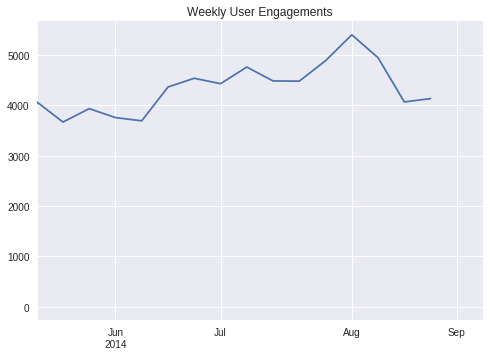

In [17]:
macs_bool = (usa_df['language']=='english') | (usa_df['device']=='spanish')
macs_df = usa_df[macs_bool]

# Let's look at only people who used macbooks
min_time = pd.Timestamp('2014-05-01 00:00:00')
max_time = pd.Timestamp('2014-09-01 00:00:00')

macs_roll = rolling_sum(macs_df, 'time_id', min_time, max_time, 7)
make_plot(macs_roll, min_time, max_time)

# Conclusion 

I think the observed drop in user engagement can be investigated further by analyzing previous year's data. It seems like this behavior is dominated bu users in the USA. I did not find any significant indication that the type of device used is driving the drop. I would recommend looking at previous years.